## Table of contents

1. [Understanding the problem](#1)
2. [Data splitting](#2)
3. [EDA](#3)
4. [Feature engineering](#4)
5. [Preprocessing and transformations](#5)
6. [Baseline model](#6)
7. [Linear models](#7)
8. [Different classifiers](#8)
9. [Feature selection](#9)
10. [Hyperparameter optimization](#10)
11. [Interpretation and feature importances](#11)
12. [Results on the test set](#12)
13. [Summary of the results](#13)

## Project Description <a id="1"></a>
<hr>

The project is about a classification problem of predicting whether a credit card client will default or not, using [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns can be used as features. (Reference [the associated research paper](https://www.sciencedirect.com/science/article/pii/S0957417407006719)) 

**Basic insights into the dataset and documentation**  
This is a binary classification problem. The task is to predict whether a credit card client will default or not. The dataset is of moderate size. The number of features is rather small. I would consider this as a small dimensional problem. All features are numerically encoded. That said, some features such as sex and marriage seem more like categorical features. 


In [1]:
# imports
import os

%matplotlib inline
import string
import sys
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

# data
from sklearn.compose import ColumnTransformer, make_column_transformer

# Classifiers
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

# classifiers / models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)

# other
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [2]:
### read in dataset
df = pd.read_csv("UCI_Credit_Card.csv")

## Data splitting <a id="2"></a>

In [3]:
### Data splitting
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)
train_df.shape

(21000, 25)

## EDA <a id="3"></a>

In [4]:
print("n=%d, d=%d" % train_df.shape)
train_df.describe()

n=21000, d=25


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,...,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,14962.348238,167880.651429,1.600762,1.852143,1.554000,35.500810,-0.015429,-0.137095,-0.171619,-0.225238,...,43486.610905,40428.518333,38767.202667,5673.585143,5.895027e+03,5311.432286,4774.021381,4751.850095,5237.762190,0.223238
std,8650.734050,130202.682167,0.489753,0.792961,0.521675,9.212644,1.120465,1.194506,1.196123,1.168556,...,64843.303993,61187.200817,59587.689549,17033.241454,2.180143e+04,18377.997079,15434.136142,15228.193125,18116.846563,0.416427
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-50616.000000,-61372.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7498.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2293.750000,1739.500000,1215.750000,1000.000000,8.200000e+02,390.000000,266.000000,234.000000,110.750000,0.000000
50%,14960.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19102.500000,18083.000000,16854.500000,2100.000000,2.007000e+03,1809.500000,1500.000000,1500.000000,1500.000000,0.000000
75%,22458.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54763.250000,50491.000000,49253.750000,5007.250000,5.000000e+03,4628.500000,4021.250000,4016.000000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.227082e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21000 entries, 16395 to 19966
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          21000 non-null  int64  
 1   LIMIT_BAL                   21000 non-null  float64
 2   SEX                         21000 non-null  int64  
 3   EDUCATION                   21000 non-null  int64  
 4   MARRIAGE                    21000 non-null  int64  
 5   AGE                         21000 non-null  int64  
 6   PAY_0                       21000 non-null  int64  
 7   PAY_2                       21000 non-null  int64  
 8   PAY_3                       21000 non-null  int64  
 9   PAY_4                       21000 non-null  int64  
 10  PAY_5                       21000 non-null  int64  
 11  PAY_6                       21000 non-null  int64  
 12  BILL_AMT1                   21000 non-null  float64
 13  BILL_AMT2                  

**Observation 1**: Seems like there are no missing values and all the columns are encoded as numeric columns. 

In [6]:
print(
    "Fraction that default:\n",
    train_df["default.payment.next.month"].value_counts(normalize=True),
)

Fraction that default:
 0    0.776762
1    0.223238
Name: default.payment.next.month, dtype: float64


**Observation 2**: We have a class imbalance. Both classes seem importance here and I am going to pick macro-average f1 score as our evaluation metric. 

In [7]:
from sklearn.metrics import f1_score, make_scorer, recall_score

custom_scorer = make_scorer(f1_score, average="macro")
scoring_metric = custom_scorer

In [8]:
np.max(train_df, axis=0)

ID                              30000.0
LIMIT_BAL                     1000000.0
SEX                                 2.0
EDUCATION                           6.0
MARRIAGE                            3.0
AGE                                79.0
PAY_0                               8.0
PAY_2                               8.0
PAY_3                               8.0
PAY_4                               8.0
PAY_5                               8.0
PAY_6                               8.0
BILL_AMT1                      964511.0
BILL_AMT2                      983931.0
BILL_AMT3                      855086.0
BILL_AMT4                      891586.0
BILL_AMT5                      927171.0
BILL_AMT6                      961664.0
PAY_AMT1                       873552.0
PAY_AMT2                      1227082.0
PAY_AMT3                       896040.0
PAY_AMT4                       621000.0
PAY_AMT5                       426529.0
PAY_AMT6                       528666.0
default.payment.next.month          1.0


In [9]:
np.min(train_df, axis=0)

ID                                 1.0
LIMIT_BAL                      10000.0
SEX                                1.0
EDUCATION                          0.0
MARRIAGE                           0.0
AGE                               21.0
PAY_0                             -2.0
PAY_2                             -2.0
PAY_3                             -2.0
PAY_4                             -2.0
PAY_5                             -2.0
PAY_6                             -2.0
BILL_AMT1                     -15308.0
BILL_AMT2                     -67526.0
BILL_AMT3                    -157264.0
BILL_AMT4                     -50616.0
BILL_AMT5                     -61372.0
BILL_AMT6                    -339603.0
PAY_AMT1                           0.0
PAY_AMT2                           0.0
PAY_AMT3                           0.0
PAY_AMT4                           0.0
PAY_AMT5                           0.0
PAY_AMT6                           0.0
default.payment.next.month         0.0
dtype: float64

In [10]:
X_train, y_train = (
    train_df.drop(columns=["default.payment.next.month"]),
    train_df["default.payment.next.month"],
)
X_test, y_test = (
    test_df.drop(columns=["default.payment.next.month"]),
    test_df["default.payment.next.month"],
)

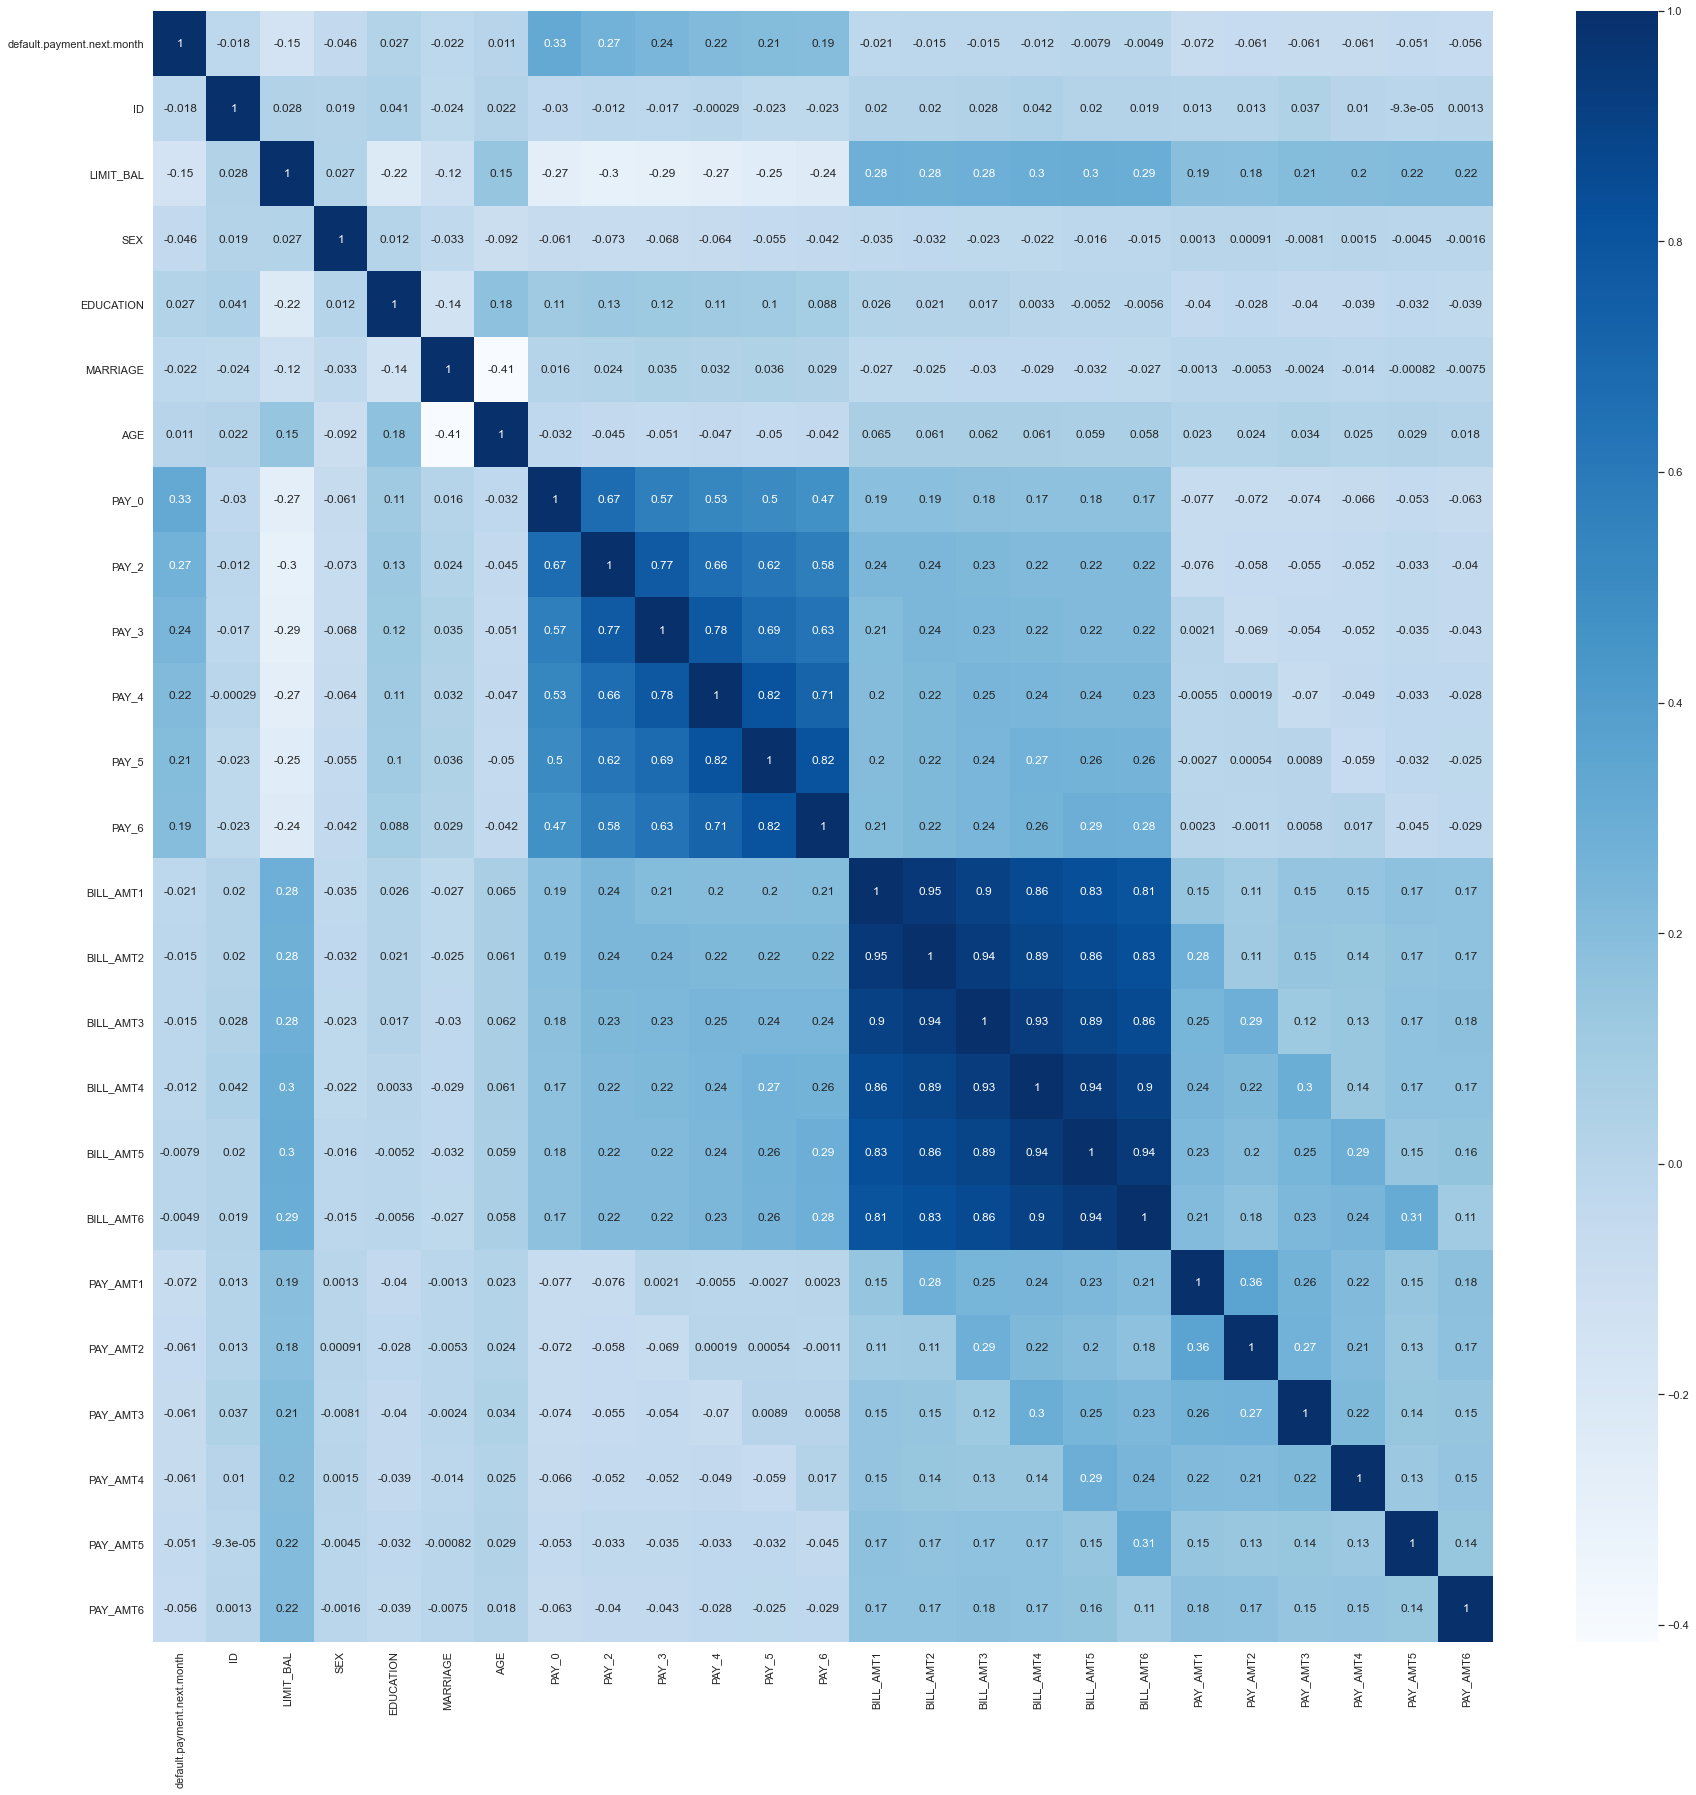

In [11]:
cor = pd.concat((y_train, X_train),axis=1).iloc[:,:30].corr();
plt.figure(figsize=(30,30))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

**Observation 3**: Seems like all `PAY_\d*` features and `BILL_AMT\d*` features are highly correlated. 

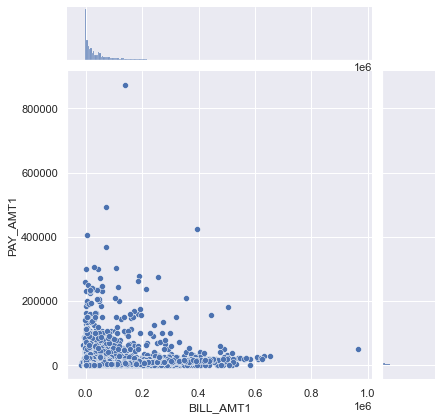

In [12]:
sns.jointplot(x="BILL_AMT1", y="PAY_AMT1", data=train_df)

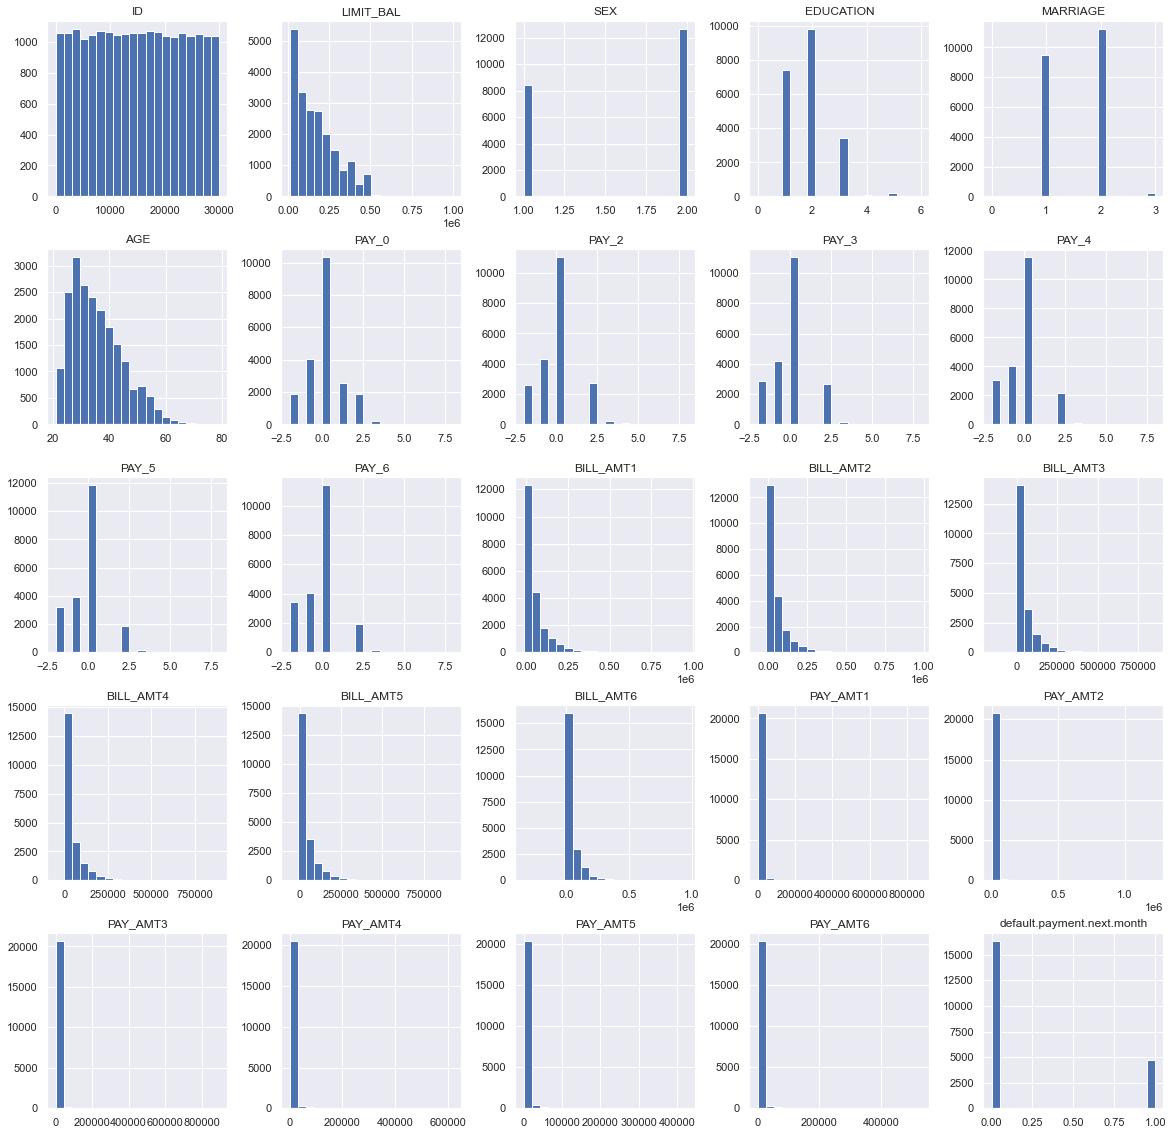

In [13]:
train_df.hist(figsize=(20,20), bins=20);

**Observation 4**: We see quite a few outliers for features such as `EDUCATION`, `MARRIAGE`, and `PAY_\d*` features. 

#### Summary of initial observations:
    
- We have very few features.
- We have class imbalance and we need to deal with it. We have chosen macro average f1 as our metric where both classes get equal weight. 
- The feature ranges are very different, so we'll need to standardize. 
- We have a number of collinear features.
- We have quite a few outliers. 
- The data is messy / doesn't always correspond to the data description. 
  - What are education levels 5 and 6?
  - What does it mean for PAY_* to be -2? Or 0?

## Feature engineering <a id='4'></a>
<hr>

In [14]:
def group_age(age):
    '''Classify ages into three categories: 1 - young, 2- middle-aged, 3- old'''
    if 20 < age <= 40:
        return 1
    elif 40 < age <= 60:
        return 2
    else:
        return 3

X_train['age_group'] = X_train['AGE'].apply(lambda x : group_age(x))
X_test['age_group'] = X_test['AGE'].apply(lambda x : group_age(x))

It is reasonble to classify cardholders into three age levels that relates to their income ability, since it doesn't make much sense for the change of probability of default when the age of a cardholder is changed by 1

## Preprocessing and transformations <a id="5"></a>
<hr>

In [1]:
# Identify numeric and categorical features
drop_features = ["ID"]
numeric_features = [
    "LIMIT_BAL",
    "PAY_0",
    "PAY_2",
    "PAY_3",
    "PAY_4",
    "PAY_5",
    "PAY_6",
    "BILL_AMT1",
    "BILL_AMT2",
    "BILL_AMT3",
    "BILL_AMT4",
    "BILL_AMT5",
    "BILL_AMT6",
    "PAY_AMT1",
    "PAY_AMT2",
    "PAY_AMT3",
    "PAY_AMT4",
    "PAY_AMT5",
    "PAY_AMT6",
    "AGE",
]
binary_features = ["SEX"]
categorical_features = ["EDUCATION", "MARRIAGE"]
target = "default.payment.next.month"

In [16]:
preprocessor = make_column_transformer(
    ("drop", drop_features),
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop="if_binary"), binary_features),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features),
)

In [17]:
# Helper function

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)


In [18]:
results = {}

## Baseline model <a id="6"></a>
<hr>

Try `scikit-learn`'s baseline model and report results.

In [19]:
dummy = DummyClassifier(strategy="stratified")
results["dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,dummy
fit_time,0.002 (+/- 0.001)
score_time,0.001 (+/- 0.000)
test_score,0.500 (+/- 0.010)
train_score,0.502 (+/- 0.007)


## Linear models <a id="7"></a>
<hr>

Use logistic regression and carry out hyperparameter tuning. Report validation scores along with standard deviation. 

In [20]:
pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=1000, class_weight="balanced")
)
results["logreg"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,dummy,logreg
fit_time,0.002 (+/- 0.001),0.259 (+/- 0.013)
score_time,0.001 (+/- 0.000),0.010 (+/- 0.000)
test_score,0.500 (+/- 0.010),0.625 (+/- 0.006)
train_score,0.502 (+/- 0.007),0.627 (+/- 0.003)


In [21]:
from scipy.stats import lognorm, loguniform, randint

param_grid = {"logisticregression__C": loguniform(1e-3, 1e3)}

random_search = RandomizedSearchCV(
    pipe_lr,
    param_grid,
    n_iter=50,
    verbose=1,
    n_jobs=1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
)

random_search.fit(X_train, y_train);

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   54.1s finished


In [22]:
print("Best hyperparameter values: ", random_search.best_params_)
print("Best score: %0.3f" % (random_search.best_score_))

pd.DataFrame(random_search.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_logisticregression__C",
        "mean_fit_time",
        "rank_test_score",
        "std_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]

Best hyperparameter values:  {'logisticregression__C': 0.011290431413903904}
Best score: 0.629


,mean_train_score,mean_test_score,param_logisticregression__C,mean_fit_time,std_test_score
rank_test_score,,,,,
1,0.630049,0.629036,0.0112904,0.070487,0.005759
2,0.630119,0.628820,0.0124437,0.079689,0.005739
3,0.629757,0.628285,0.00493981,0.055626,0.006232
4,0.630345,0.628241,0.0229672,0.083590,0.006073
5,0.630344,0.628159,0.0234196,0.082535,0.005999
6,0.629813,0.627771,0.00356968,0.055384,0.005548
7,0.629775,0.627648,0.0318223,0.094943,0.005572
8,0.629114,0.627397,0.0022807,0.048682,0.005280
9,0.629114,0.627311,0.0578475,0.109491,0.005274


In [23]:
best_logreg = random_search.best_estimator_
results["logreg (tuned)"] = mean_std_cross_val_scores(
    best_logreg, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.002 (+/- 0.001),0.001 (+/- 0.000),0.500 (+/- 0.010),0.502 (+/- 0.007)
logreg,0.259 (+/- 0.013),0.010 (+/- 0.000),0.625 (+/- 0.006),0.627 (+/- 0.003)
logreg (tuned),0.066 (+/- 0.003),0.009 (+/- 0.002),0.629 (+/- 0.006),0.630 (+/- 0.003)


**Report of LinearRegression model**

- Logistic regression scores are better than the dummy classifier scores. 
- Optimizing the regularization hyperparameter of logistic regression improved the validation scores slightly (from 0.625 to 0.629) but not by much. 
- In both cases it seems like we are underfitting; there is not much gap between train and validation scores. Probably non-linear models might be a better choice here. 

## Non-linear classifiers <a id="8"></a>
<hr>

In [24]:
ratio = np.bincount(y_train)[0] / np.bincount(y_train)[1]
ratio

3.4795221843003414

In [25]:
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    "RBF SVM": SVC(),
    "random forest": RandomForestClassifier(class_weight="balanced", random_state=2),
    "xgboost": XGBClassifier(scale_pos_weight=ratio, random_state=2),
    "lgbm": LGBMClassifier(scale_pos_weight=ratio, random_state=2),
}

for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results[name] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.002 (+/- 0.001),0.001 (+/- 0.000),0.500 (+/- 0.010),0.502 (+/- 0.007)
logreg,0.259 (+/- 0.013),0.010 (+/- 0.000),0.625 (+/- 0.006),0.627 (+/- 0.003)
logreg (tuned),0.066 (+/- 0.003),0.009 (+/- 0.002),0.629 (+/- 0.006),0.630 (+/- 0.003)
RBF SVM,7.333 (+/- 0.099),0.887 (+/- 0.027),0.675 (+/- 0.008),0.686 (+/- 0.002)
random forest,2.307 (+/- 0.034),0.065 (+/- 0.001),0.668 (+/- 0.003),0.999 (+/- 0.000)
xgboost,0.363 (+/- 0.005),0.011 (+/- 0.000),0.681 (+/- 0.006),0.868 (+/- 0.004)
lgbm,0.125 (+/- 0.005),0.010 (+/- 0.000),0.691 (+/- 0.011),0.772 (+/- 0.004)


### Report

- I am using four non-linear models here: RBF SVM and three tree-based models. 
- We are trying all models with default hyperparameters. 
- Similar to logistic regression, SVC also seems to underfit; the gap between train and test scores are not large. Also, as expected, it takes longer to `fit` compared to other models. Let's abandon it. 
- LGBM seems to be the best performing model among the tree-based models. It also seems to be much faster and overfitting less compared to random forest and xgboost. That said, it's std is higher than the other two models. 

In [26]:
del models["RBF SVM"]

## Feature selection <a id="9"></a>
<hr>

Select relevant features using `RFECV`, forward selection or L1 regularization.

In [27]:
from sklearn.feature_selection import RFE, RFECV, SelectFromModel

for name, model in models.items():
    pipe = make_pipeline(
        preprocessor,
        SelectFromModel(
            LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
        ),
        model,
    )
    results[name + "+ feat_sel"] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

In [28]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.002 (+/- 0.001),0.001 (+/- 0.000),0.500 (+/- 0.010),0.502 (+/- 0.007)
logreg,0.259 (+/- 0.013),0.010 (+/- 0.000),0.625 (+/- 0.006),0.627 (+/- 0.003)
logreg (tuned),0.066 (+/- 0.003),0.009 (+/- 0.002),0.629 (+/- 0.006),0.630 (+/- 0.003)
RBF SVM,7.333 (+/- 0.099),0.887 (+/- 0.027),0.675 (+/- 0.008),0.686 (+/- 0.002)
random forest,2.307 (+/- 0.034),0.065 (+/- 0.001),0.668 (+/- 0.003),0.999 (+/- 0.000)
xgboost,0.363 (+/- 0.005),0.011 (+/- 0.000),0.681 (+/- 0.006),0.868 (+/- 0.004)
lgbm,0.125 (+/- 0.005),0.010 (+/- 0.000),0.691 (+/- 0.011),0.772 (+/- 0.004)
random forest+ feat_sel,3.077 (+/- 0.197),0.067 (+/- 0.002),0.670 (+/- 0.007),0.999 (+/- 0.000)
xgboost+ feat_sel,1.053 (+/- 0.241),0.013 (+/- 0.001),0.684 (+/- 0.009),0.865 (+/- 0.005)
lgbm+ feat_sel,0.732 (+/- 0.337),0.011 (+/- 0.001),0.691 (+/- 0.008),0.772 (+/- 0.003)


Examine how many features were selected for the random forest classifier.

In [29]:
pipe_random_forest = make_pipeline(
    preprocessor,
    SelectFromModel(
        LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
    ),
    models["random forest"],
)

pipe_random_forest.fit(X_train, y_train)
print(
    "Number of features selected: ",
    pipe_random_forest.named_steps["randomforestclassifier"].n_features_,
)

Number of features selected:  29


**Report of feature selection**

Total 29 features were selected by L2 regularization. We see very small improvements in the result with logistic regression and L2 regularization. But not a lot. Also, we do not have a large number of features. So let's abandon feature selection from the pipeline. 

## Hyperparameter optimization <a id="10"></a>
<hr>

Optimize hyperparameters for the models I tried above and summarize the results. (Further work: try Bayesian optimization methods. [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize))

#### Random forest hyperparameter optimization 

In [30]:
param_grid_rf = {
    "randomforestclassifier__n_estimators": randint(low=10, high=100),
    "randomforestclassifier__max_depth": randint(low=2, high=20),
}

pipe_random_forest = make_pipeline(preprocessor, models["random forest"])

In [31]:
random_search_rf = RandomizedSearchCV(
    pipe_random_forest,
    param_grid_rf,
    n_iter=50,
    verbose=1,
    n_jobs=1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
)

random_search_rf.fit(X_train, y_train);


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  3.5min finished


In [32]:
print("Best hyperparameter values: ", random_search_rf.best_params_)
print("Best score: %0.3f" % (random_search_rf.best_score_))

pd.DataFrame(random_search_rf.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_randomforestclassifier__n_estimators",
        "param_randomforestclassifier__max_depth",
        "mean_fit_time",
        "rank_test_score",
        "std_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]


Best hyperparameter values:  {'randomforestclassifier__max_depth': 11, 'randomforestclassifier__n_estimators': 62}
Best score: 0.706


,mean_train_score,mean_test_score,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_depth,mean_fit_time,std_test_score
rank_test_score,,,,,,
1,0.792021,0.705589,62,11,0.982717,0.010398
2,0.815615,0.704876,79,12,1.322302,0.008913
3,0.814653,0.703748,67,12,1.137913,0.009522
4,0.706073,0.703600,86,4,0.631805,0.009061
5,0.706940,0.703481,27,4,0.217240,0.008128
6,0.768482,0.703388,35,10,0.551053,0.009720
7,0.752798,0.703367,76,9,1.023794,0.008657
8,0.705913,0.702910,68,4,0.497493,0.009073
9,0.839467,0.702758,68,13,1.241852,0.008306


In [33]:
best_rf_model = random_search_rf.best_estimator_
results["random forest (tuned)"] = mean_std_cross_val_scores(
    best_rf_model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T


,fit_time,score_time,test_score,train_score
dummy,0.002 (+/- 0.001),0.001 (+/- 0.000),0.500 (+/- 0.010),0.502 (+/- 0.007)
logreg,0.259 (+/- 0.013),0.010 (+/- 0.000),0.625 (+/- 0.006),0.627 (+/- 0.003)
logreg (tuned),0.066 (+/- 0.003),0.009 (+/- 0.002),0.629 (+/- 0.006),0.630 (+/- 0.003)
RBF SVM,7.333 (+/- 0.099),0.887 (+/- 0.027),0.675 (+/- 0.008),0.686 (+/- 0.002)
random forest,2.307 (+/- 0.034),0.065 (+/- 0.001),0.668 (+/- 0.003),0.999 (+/- 0.000)
xgboost,0.363 (+/- 0.005),0.011 (+/- 0.000),0.681 (+/- 0.006),0.868 (+/- 0.004)
lgbm,0.125 (+/- 0.005),0.010 (+/- 0.000),0.691 (+/- 0.011),0.772 (+/- 0.004)
random forest+ feat_sel,3.077 (+/- 0.197),0.067 (+/- 0.002),0.670 (+/- 0.007),0.999 (+/- 0.000)
xgboost+ feat_sel,1.053 (+/- 0.241),0.013 (+/- 0.001),0.684 (+/- 0.009),0.865 (+/- 0.005)
lgbm+ feat_sel,0.732 (+/- 0.337),0.011 (+/- 0.001),0.691 (+/- 0.008),0.772 (+/- 0.003)


#### LGBM hyperparameter optimization 

In [34]:
param_grid_lgbm = {
    "lgbmclassifier__n_estimators": randint(10, 100),
    # "lgbmclassifier__max_depth": randint(low=2, high=20),
    "lgbmclassifier__learning_rate": [0.01, 0.1],
    "lgbmclassifier__subsample": [0.5, 0.75, 1],
}

pipe_lgbm = make_pipeline(
    preprocessor,
    models["lgbm"],
)


In [35]:
random_search_lgbm = RandomizedSearchCV(
    pipe_lgbm,
    param_grid_lgbm,
    n_iter=50,
    verbose=1,
    n_jobs=1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
)

random_search_lgbm.fit(X_train, y_train);


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   34.7s finished


In [36]:
print("Best hyperparameter values: ", random_search_lgbm.best_params_)
print("Best score: %0.3f" % (random_search_lgbm.best_score_))

pd.DataFrame(random_search_lgbm.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_lgbmclassifier__n_estimators",
        "param_lgbmclassifier__learning_rate",
        "param_lgbmclassifier__subsample",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]


Best hyperparameter values:  {'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__n_estimators': 13, 'lgbmclassifier__subsample': 0.5}
Best score: 0.707


,mean_train_score,mean_test_score,param_lgbmclassifier__n_estimators,param_lgbmclassifier__learning_rate,param_lgbmclassifier__subsample,mean_fit_time
rank_test_score,,,,,,
1,0.718904,0.706997,13,0.1,0.5,0.054972
2,0.719469,0.706529,11,0.1,0.5,0.052386
2,0.719469,0.706529,11,0.1,1,0.057537
4,0.721328,0.704935,17,0.1,1,0.064251
5,0.710473,0.701874,94,0.01,0.5,0.152824
6,0.722566,0.698224,22,0.1,1,0.066770
7,0.723291,0.697680,24,0.1,1,0.069572
8,0.702752,0.695554,86,0.01,0.5,0.159779
9,0.728293,0.691679,35,0.1,1,0.072961


In [37]:
best_lgbm_model = random_search_lgbm.best_estimator_
results["lgbm (tuned)"] = mean_std_cross_val_scores(
    best_lgbm_model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T


,fit_time,score_time,test_score,train_score
dummy,0.002 (+/- 0.001),0.001 (+/- 0.000),0.500 (+/- 0.010),0.502 (+/- 0.007)
logreg,0.259 (+/- 0.013),0.010 (+/- 0.000),0.625 (+/- 0.006),0.627 (+/- 0.003)
logreg (tuned),0.066 (+/- 0.003),0.009 (+/- 0.002),0.629 (+/- 0.006),0.630 (+/- 0.003)
RBF SVM,7.333 (+/- 0.099),0.887 (+/- 0.027),0.675 (+/- 0.008),0.686 (+/- 0.002)
random forest,2.307 (+/- 0.034),0.065 (+/- 0.001),0.668 (+/- 0.003),0.999 (+/- 0.000)
xgboost,0.363 (+/- 0.005),0.011 (+/- 0.000),0.681 (+/- 0.006),0.868 (+/- 0.004)
lgbm,0.125 (+/- 0.005),0.010 (+/- 0.000),0.691 (+/- 0.011),0.772 (+/- 0.004)
random forest+ feat_sel,3.077 (+/- 0.197),0.067 (+/- 0.002),0.670 (+/- 0.007),0.999 (+/- 0.000)
xgboost+ feat_sel,1.053 (+/- 0.241),0.013 (+/- 0.001),0.684 (+/- 0.009),0.865 (+/- 0.005)
lgbm+ feat_sel,0.732 (+/- 0.337),0.011 (+/- 0.001),0.691 (+/- 0.008),0.772 (+/- 0.003)


**Summary of observations**

Hyperparameter optimization seems to help with random forests as well as LightGBM. The scores for both models seem very similar. But we pick LightGBM because
- it seems to be less overfitting 
- it's much faster
- the standard deviation is smaller compared to random forest. 

## Interpretation and feature importances <a id="11"></a>
<hr>

Explain the best model and the important features in various perspectives using `eli5` and `shap`.

In [64]:
import eli5

binary_OHE = list(
    best_lgbm_model.named_steps["columntransformer"]
    .named_transformers_["onehotencoder-1"]
    .get_feature_names(binary_features)
)

categorical_OHE = list(
    best_lgbm_model.named_steps["columntransformer"]
    .named_transformers_["onehotencoder-2"]
    .get_feature_names(categorical_features)
)

feature_names = numeric_features + binary_OHE + categorical_OHE

eli5.show_weights(
    best_lgbm_model.named_steps["lgbmclassifier"],
    feature_names=feature_names,
)

Weight,Feature
0.5927,PAY_0
0.0585,PAY_AMT2
0.0431,LIMIT_BAL
0.0417,BILL_AMT1
0.0278,PAY_4
0.0277,PAY_2
0.0275,PAY_3
0.0259,PAY_AMT3
0.0226,PAY_AMT4
0.0195,PAY_AMT1


In [39]:
import shap

preprocessor.fit(X_train, y_train)

X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)

X_train_enc.head()


,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,...,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
16395,1.168355,0.013770,0.114774,0.143483,0.192754,0.232531,0.257059,-0.300665,-0.293394,-0.265310,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
21448,2.090017,-0.878738,-0.722412,-0.692571,0.192754,0.232531,0.257059,-0.685307,-0.679495,0.585444,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20034,-0.060527,-1.771246,-1.559598,-1.528626,-1.518801,-1.526210,-1.485154,-0.696132,-0.688319,-0.681234,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25755,-0.367748,0.013770,0.114774,0.143483,0.192754,0.232531,0.257059,0.687456,0.752583,0.835581,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1438,-0.905384,0.906278,1.789147,0.143483,0.192754,0.232531,0.257059,-0.040230,-0.031399,-0.287429,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [40]:
lgbm_tuned = LGBMClassifier(
    scale_pos_weight=ratio,
    random_state=2,
    learning_rate=random_search_lgbm.best_params_["lgbmclassifier__learning_rate"],
    n_estimators=random_search_lgbm.best_params_["lgbmclassifier__n_estimators"],
    subsample=random_search_lgbm.best_params_["lgbmclassifier__subsample"],
)

lgbm_tuned.fit(X_train_enc, y_train)
lgbm_explainer = shap.TreeExplainer(lgbm_tuned)
lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [41]:
values = np.abs(lgbm_shap_values[0]).mean(0)
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:10]


,SHAP
PAY_0,0.379010
LIMIT_BAL,0.129931
PAY_AMT2,0.093941
BILL_AMT1,0.086548
PAY_AMT3,0.059370
PAY_2,0.051485
PAY_3,0.050122
PAY_AMT1,0.044178
PAY_AMT4,0.043867
PAY_4,0.039639


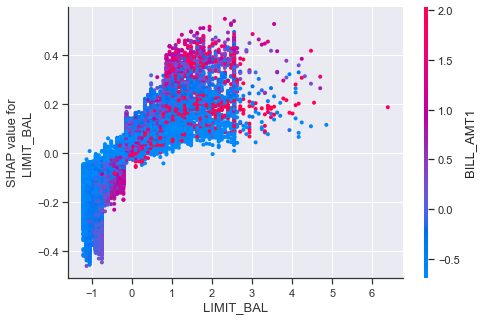

In [42]:
shap.dependence_plot("LIMIT_BAL", lgbm_shap_values[0], X_train_enc)


As `LIMIT_BAL` increases, SHAP values for class 0 increase as well, suggesting that class is likely to be 0 (non default) with higher values for LIMIT_BAL, which makes sense.    


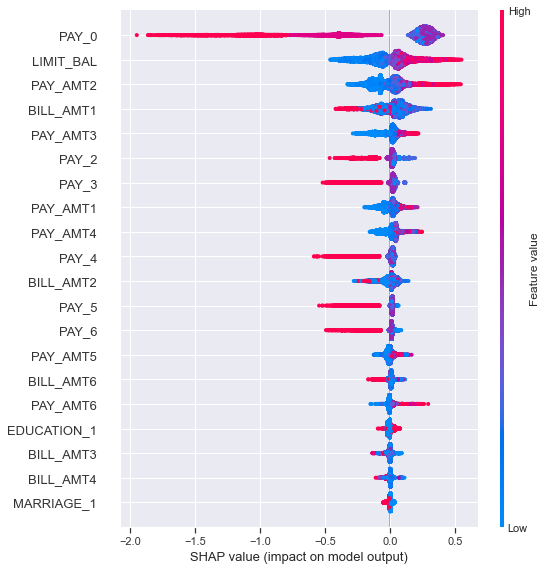

In [43]:
shap.summary_plot(lgbm_shap_values[0], X_train_enc)


In [44]:
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [45]:
lgbm_tuned.predict_proba(X_test_enc)[1]


array([0.74058038, 0.25941962])

In [46]:
lgbm_tuned.predict(X_test_enc, raw_score=True)[1]


-1.0489872894312522

In [47]:
lgbm_explainer.expected_value


[0.5594117098974121, -0.5594117098974121]

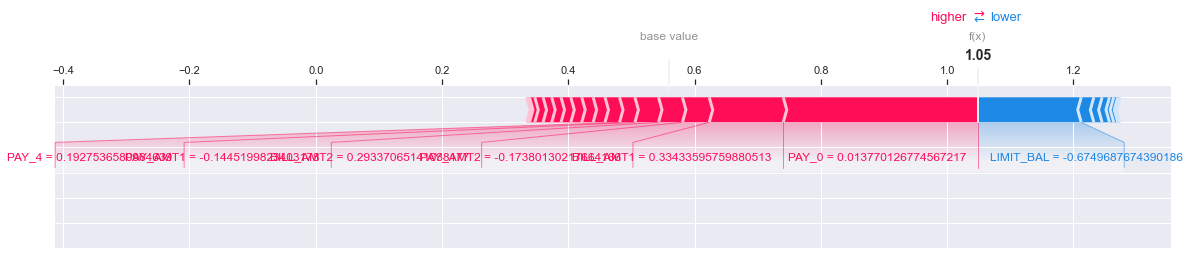

In [48]:
shap.force_plot(
    lgbm_explainer.expected_value[0],
    test_lgbm_shap_values[0][1, :],
    X_test_enc.iloc[1, :],
    matplotlib=True,
)


**Summary of observations**
- From the analysis above we observe that **PAY_\d{0,2,3,4}**, **PAY_AMT**, **LIM_BAL** features seem to be one of the most important features with `PAY_0` being the topmost feature. 
- The SHAP dependence plot demonstrates that the class is likely to be 0 (non default) for higher values for LIMIT_BAL, which makes sense.
- The features `EDUCATION` and `SEX` doesn't seem to influence the prediction much. This might be because of the noise in the `EDUCTION` column; there are a number of unknown values in this column.  


## Results on the test set <a id="12"></a>
<hr>

Try your best performing model on the test data and report test scores. 

In [49]:
from sklearn.metrics import f1_score

best_model = random_search_lgbm.best_estimator_
print("Grid Search best model validation score: %0.3f" % (random_search_lgbm.best_score_))

predictions = best_model.predict(X_test)
print(
    "Macro-average f1 score on the test set: %0.3f"
    % (f1_score(y_test, predictions, average="macro"))
)


Grid Search best model validation score: 0.707
Macro-average f1 score on the test set: 0.695


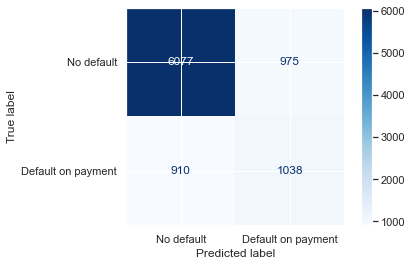

In [50]:
from sklearn.metrics import classification_report

plot_confusion_matrix(
    best_model,
    X_test,
    y_test,
    display_labels=["No default", "Default on payment"],
    values_format="d",
    cmap=plt.cm.Blues,
)


In [51]:
print(
    classification_report(
        y_test, predictions, target_names=["No default", "Default on payment"]
    )
)


                    precision    recall  f1-score   support

        No default       0.87      0.86      0.87      7052
Default on payment       0.52      0.53      0.52      1948

          accuracy                           0.79      9000
         macro avg       0.69      0.70      0.69      9000
      weighted avg       0.79      0.79      0.79      9000



**Report**

The macro-average f1-score (0.695) on the held-out test set is pretty much in line with the macro-average f1-score validation score (0.707). So there doesn't seem to be severe optimization bias here.


**Explain a default and a non-default test prediction using SHAP force plot**

In [52]:
y_test_reset = y_test.reset_index(drop=True)
non_default_ind = y_test_reset[y_test_reset == 0].index.tolist()
default_ind = y_test_reset[y_test_reset == 1].index.tolist()

ex_non_default_index = non_default_ind[0]
ex_default_index = default_ind[0]


* __Explanation of a non-default prediction__

In [53]:
lgbm_tuned.predict_proba(X_test_enc)[ex_non_default_index]


array([0.697763, 0.302237])

In [54]:
lgbm_tuned.predict(X_test_enc, raw_score=True)[ex_non_default_index]


-0.8366680315908269

In [55]:
lgbm_explainer.expected_value

[0.5594117098974121, -0.5594117098974121]

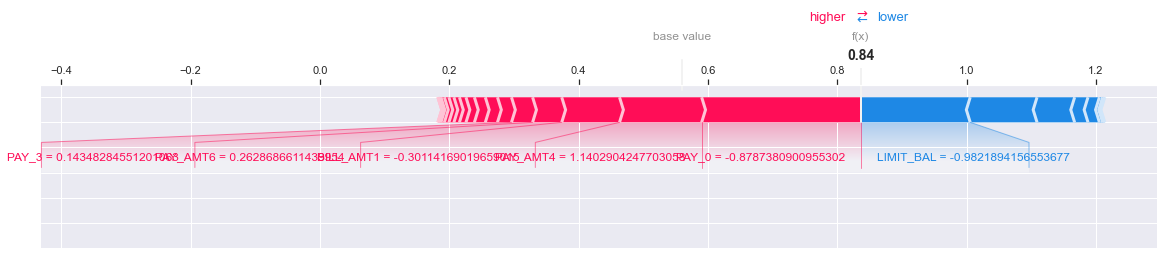

In [56]:
shap.force_plot(
    lgbm_explainer.expected_value[0],
    test_lgbm_shap_values[0][ex_non_default_index, :],
    X_test_enc.iloc[ex_non_default_index, :],
    matplotlib=True,
)


__Summary__  
The raw model score is 0.84, which is greater than the base value 0.5594 and so the prediction is that the user is not likely to default on credit payment (because we are consider the shap values for class 0). 


* **Explanation of a default prediction**

In [57]:
lgbm_tuned.predict_proba(X_test_enc)[ex_default_index]


array([0.26909715, 0.73090285])

In [58]:
lgbm_tuned.predict(X_test_enc, raw_score=True)[ex_default_index]


0.9992080664830868

In [59]:
lgbm_explainer.expected_value


[0.5594117098974121, -0.5594117098974121]

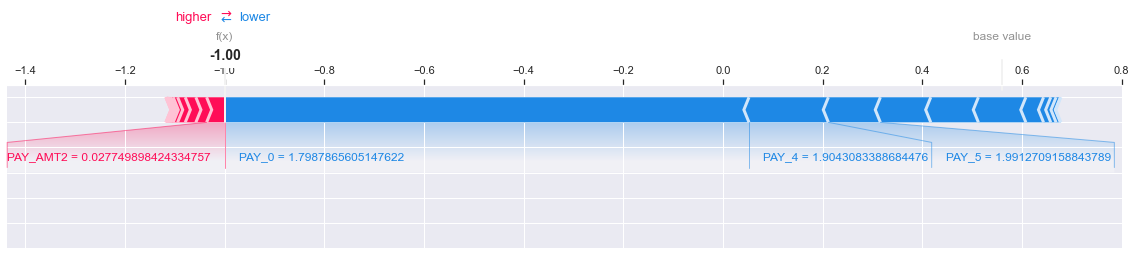

In [60]:
shap.force_plot(
    lgbm_explainer.expected_value[0],
    test_lgbm_shap_values[0][ex_default_index, :],
    X_test_enc.iloc[ex_default_index, :],
    matplotlib=True,
)


**Summary**
- The raw model score is -1.00, which is smaller than the base value 0.5594 and so the prediction is that the user is likely to default on the credit payment (class 1). 
- Positive values for PAY_* variables seem to push the prediction towards a lower value. 


## Summary of the important results <a id="13"></a>
<hr>


In [61]:
pd.DataFrame(results).T
summary_df = pd.DataFrame(results).T


In [62]:
comments = {
    "dummy": "Baseline of 0.50 macro-average f1 score.",
    "logreg": "Improvement over the baseline but underfitting.",
    "logreg (tuned)": "Slight improvement but still underfitting.",
    "RBF SVM": "Improvement over tuned logistic regression but slow.",
    "random forest": "Improvement over tuned logistic regression but overfitting.",
    "xgboost": "Best results so far and less overfitting compared to random forest.",
    "lgbm": "Improvement over xgboost and less overfitting.",
    "random forest+ feat_sel": "Feature selection with L1 regularization helps a tiny bit. Selects 29 features.",
    "xgboost+ feat_sel": "Very tiny improvement with L1 feature selection.",
    "lgbm+ feat_sel": "No improvemnt with L1 feature selection.",
    "random forest (tuned)": "Hyperparameter optimization helped! Best results so far.",
    "lgbm (tuned)": "Hyperparameter optimization helped. Best results overall! The scores are very similar to random forest scores but picking this as the best model for its speed.",
}
pd.set_option('display.max_colwidth', 0)
summary_df["comments"] = comments.values()
summary_df


,fit_time,score_time,test_score,train_score,comments
dummy,0.002 (+/- 0.001),0.001 (+/- 0.000),0.500 (+/- 0.010),0.502 (+/- 0.007),Baseline of 0.50 macro-average f1 score.
logreg,0.259 (+/- 0.013),0.010 (+/- 0.000),0.625 (+/- 0.006),0.627 (+/- 0.003),Improvement over the baseline but underfitting.
logreg (tuned),0.066 (+/- 0.003),0.009 (+/- 0.002),0.629 (+/- 0.006),0.630 (+/- 0.003),Slight improvement but still underfitting.
RBF SVM,7.333 (+/- 0.099),0.887 (+/- 0.027),0.675 (+/- 0.008),0.686 (+/- 0.002),Improvement over tuned logistic regression but slow.
random forest,2.307 (+/- 0.034),0.065 (+/- 0.001),0.668 (+/- 0.003),0.999 (+/- 0.000),Improvement over tuned logistic regression but overfitting.
xgboost,0.363 (+/- 0.005),0.011 (+/- 0.000),0.681 (+/- 0.006),0.868 (+/- 0.004),Best results so far and less overfitting compared to random forest.
lgbm,0.125 (+/- 0.005),0.010 (+/- 0.000),0.691 (+/- 0.011),0.772 (+/- 0.004),Improvement over xgboost and less overfitting.
random forest+ feat_sel,3.077 (+/- 0.197),0.067 (+/- 0.002),0.670 (+/- 0.007),0.999 (+/- 0.000),Feature selection with L1 regularization helps a tiny bit. Selects 29 features.
xgboost+ feat_sel,1.053 (+/- 0.241),0.013 (+/- 0.001),0.684 (+/- 0.009),0.865 (+/- 0.005),Very tiny improvement with L1 feature selection.
lgbm+ feat_sel,0.732 (+/- 0.337),0.011 (+/- 0.001),0.691 (+/- 0.008),0.772 (+/- 0.003),No improvemnt with L1 feature selection.


#### Concluding remarks

All our models beat the baseline. Our best model was LightGBM classifier with tuned hyperparameters. It achieved cross-validation macro-average f1 score of 0.707. The scores do not seem to overfit much; the gap between mean train score (0.719) and mean cross-validation score (0.707) is not big. These scores are very similar to the tuned random forest. But random forest seems to overfit. Also, it's much slower than LightGBM. So picked LightGBM model as our final model.  

We observed the macro-average f1 score of 0.695 using this model on the held out test set, which is in line with mean cross-validation macro-average f1-score (0.707). So there doesn't seem to be severe optimization bias here.

We observed that L1 feature selection helped a tiny bit for random forests. But we did not observe any improvement in LightGBM scores with feature selection in the pipeline. In general, we have small number of features in this problem and feature selection doesn't seem crucial. 

Our analysis of feature importances shows that our `PAY_\d{0,2}`, `LIMIT_*`, and `PAY_AMT*` variables seems to be most important features. Although `SEX` feature doesn't show up as one of the most important features, depending upon the context it might be a good idea to drop this feature from our analysis. 


#### Other ideas
    
- Preprocessing and feature engineering     
    - The `BILL_AMT*` and `PAY_AMT*` variables are the bill amount, and amount paid, respectively. We could try making new features by subtracting or otherwise combining these, which would be the amount you paid relative to the amount owed.
    - There are a number of collinear features in the dataset, especially, our `PAY_\d{0,5}` features, which are one of the topmost important features. We could create new features by combining these features.     
    - More data cleaning would probably help. 
    - In my opinion, data cleaning and feature engineering are very important here.
    
- More careful hyperparameter optimization 
    - Because of limited time, we did not carry out extensive hyperparameter optimization. For instance, we didn't carry out hyperparameter optimization with the XGBoost model. It might be worth exploring this area a bit more.  
